# AeroSandbox Dynamics Stack without Optimization

Suppose we have a problem where, for some reason, we just want to use the ASB Dynamics stack as a calculator for equations of motions.

An example of such a scenario would be when you wish to simply simulate the "hands-off" flight dynamics of a vehicle.

We could just use the `Opti` stack as we have in the previous tutorials, but that's a bit overkill - we can get away with just using an off-the-shelf integrator like `scipy.integrate` using equations of motion provided by AeroSandbox.

## Example

Let's imagine that it's your birthday and your friends have gotten you a nice helium balloon to celebrate. After a long day of celebration, you release it into the sky with little concern for where it might fall. Where does the balloon go?

Let's say the balloon is a sphere filled with helium. Say the balloon rubber has a mass of 5 grams, and that the balloon is inflated such that it has a diameter of 10" at sea level. Suppose the balloon is infinitely elastic and doesn't pop. What happens to the balloon after your release it?

First, let's set up some dynamics. We'll use a 2D dynamics engine that assumes the object is a point mass, with velocity parameterized in Cartesian coordinates:

In [431]:
import aerosandbox as asb
import aerosandbox.numpy as np

dyn_template = asb.DynamicsPointMass2DCartesian()


The state variables are:

In [432]:
state_names = dyn_template.state.keys()
for name in state_names:
    print(name)

x_e
z_e
u_e
w_e


Let's do a bit of math about our balloon:

In [433]:
from aerosandbox.atmosphere.atmosphere import gas_constant_universal
from aerosandbox.tools import units as u

mass_rubber = 0.005

atmo_sea_level = asb.Atmosphere(altitude=0)
volume_sea_level = 4 / 3 * np.pi * ((10 * u.inch) / 2) ** 3
helium_molar_mass = 4.002602e-3  # kg/mol

mass_helium = (  # PV=nRT
        atmo_sea_level.pressure() *
        volume_sea_level *
        helium_molar_mass /
        gas_constant_universal /
        atmo_sea_level.temperature()
)
mass = mass_rubber + mass_helium
mass_props = asb.MassProperties(mass=mass)

Now, we can set up some equations of motion, driven by AeroSandbox:

In [434]:
def get_dyn(y):
    dyn = asb.DynamicsPointMass2DCartesian(
        mass_props=mass_props,
    )
    return dyn.get_new_instance_with_state(
        dyn.pack_state(y)
    )


def equations_of_motion(t, y):
    g_local = 9.81  # Ignoring gravity loss

    dyn = get_dyn(y)
    dyn.add_gravity_force(g=g_local)

    ### Add buoyancy
    volume = (  # PV=nRT
            mass_helium /
            helium_molar_mass *
            gas_constant_universal *
            dyn.op_point.atmosphere.temperature() /  # Note, the temperature changes significantly with altitude
            dyn.op_point.atmosphere.pressure()
    )
    radius = (volume * 3 / 4 / np.pi) ** (1 / 3)
    air_mass_displaced = volume * dyn.op_point.atmosphere.density()

    dyn.add_force(
        Fz=-air_mass_displaced * g_local,  # Upwards force == negative-z direction
        axes="earth",
    )

    ### Add drag
    CD = 0.4  # Valid for roughly 1e3 < Re < 2e5, the range of interest.
    drag_force = dyn.op_point.dynamic_pressure() * CD * (np.pi * radius ** 2)
    dyn.add_force(
        Fx=-drag_force,
        axes="wind"
    )

    return dyn.unpack_state(dyn.state_derivatives())

And now we can implement these equations of motion using an off-the-shelf integrator:

In [435]:
from scipy import integrate

time = np.cosspace(0, 24 * 3600, 1000)


def max_height(t, y):
    dyn = get_dyn(y)
    return dyn.altitude - 2e5


max_height.terminal = True

res = integrate.solve_ivp(
    fun=equations_of_motion,
    t_span=(time.min(), time.max()),
    t_eval=time,
    y0=dyn_template.unpack_state({
        "x_e": 0,
        "z_e": 0,
        "u_e": 0,
        "w_e": 0,
    }),
    events=max_height,
    vectorized=True,
    method='LSODA'
)

We can even use the AeroSandbox dynamics engine to postprocess, too:

In [436]:
time = res.t
dyn = get_dyn(res.y)

And we can plot the solution:

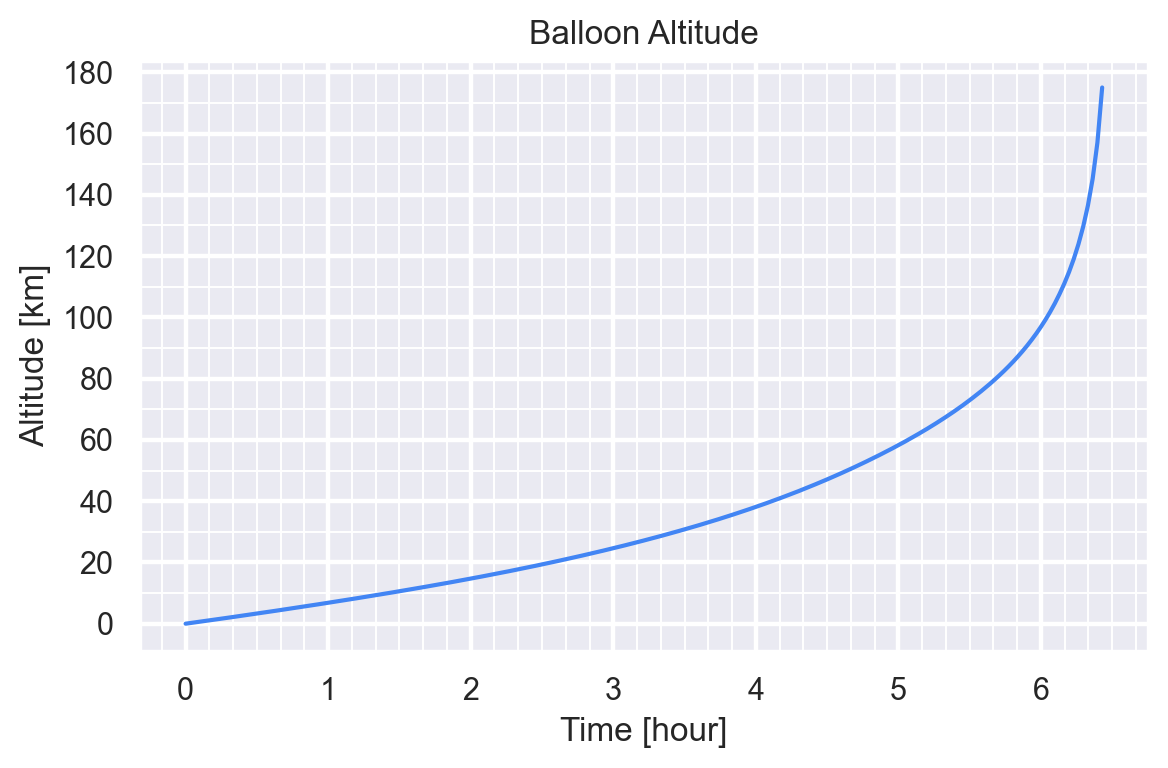

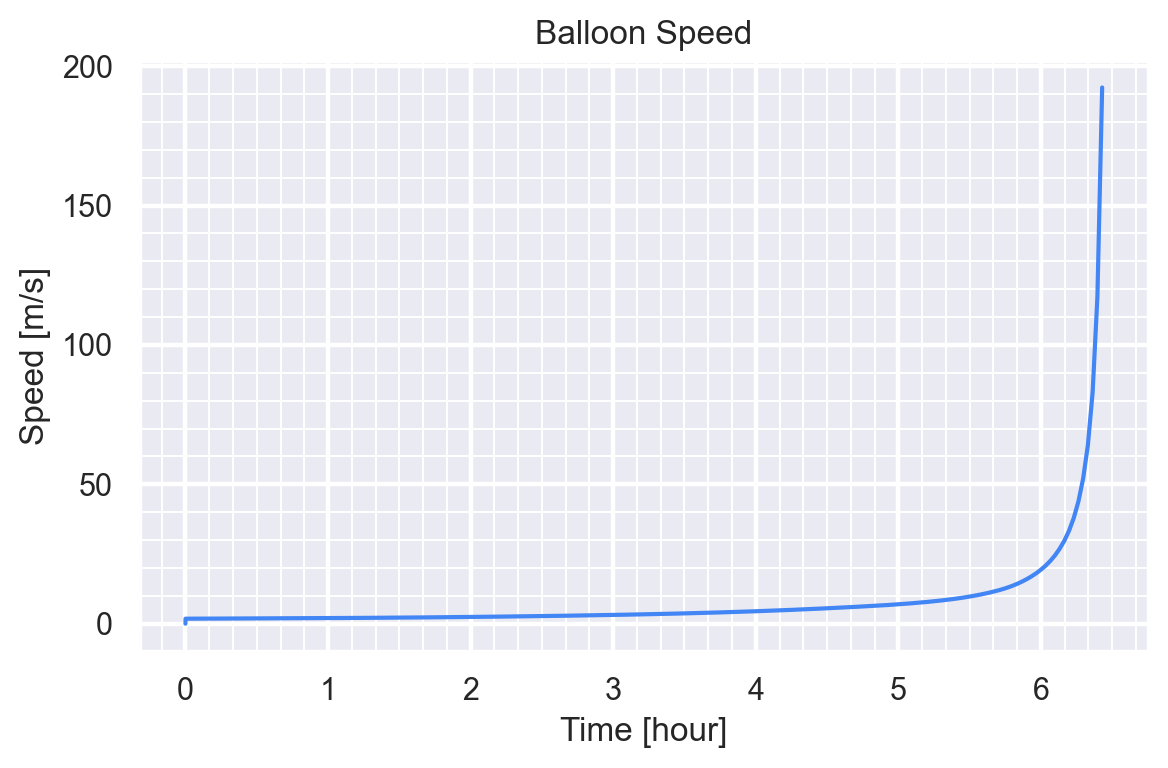

In [437]:
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

hour = time / u.hour

fig, ax = plt.subplots()
plt.plot(hour, dyn.altitude / 1e3)
p.set_ticks(1, 1 / 6, 20, 10)
p.show_plot("Balloon Altitude", "Time [hour]", "Altitude [km]")

fig, ax = plt.subplots()
plt.plot(hour, dyn.speed)
p.set_ticks(1, 1 / 6, 50, 10)
p.show_plot("Balloon Speed", "Time [hour]", "Speed [m/s]")

There's an interesting, and perhaps un-intuitive observation here: The balloon continues to rise indefinitely (and in fact, at an ever-increasing rate).

What's going on here?

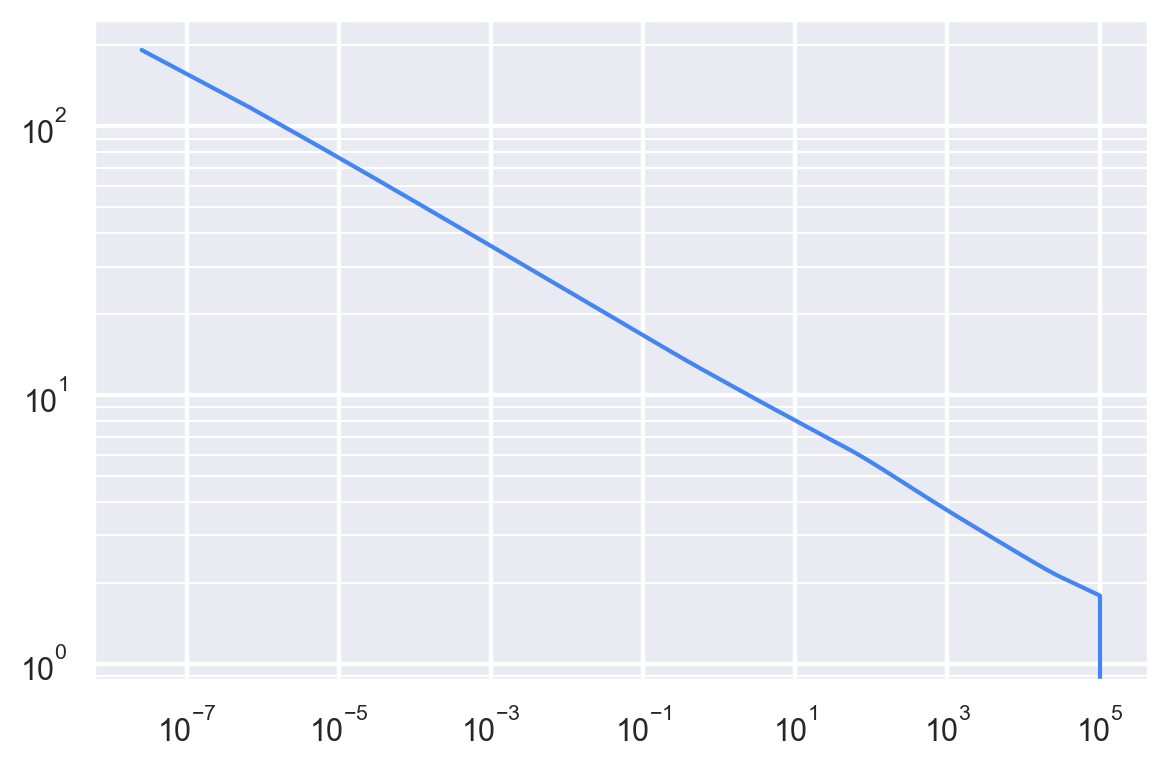

In [438]:
fig, ax = plt.subplots()
plt.loglog(dyn.op_point.atmosphere.pressure(), dyn.speed)
p.show_plot()

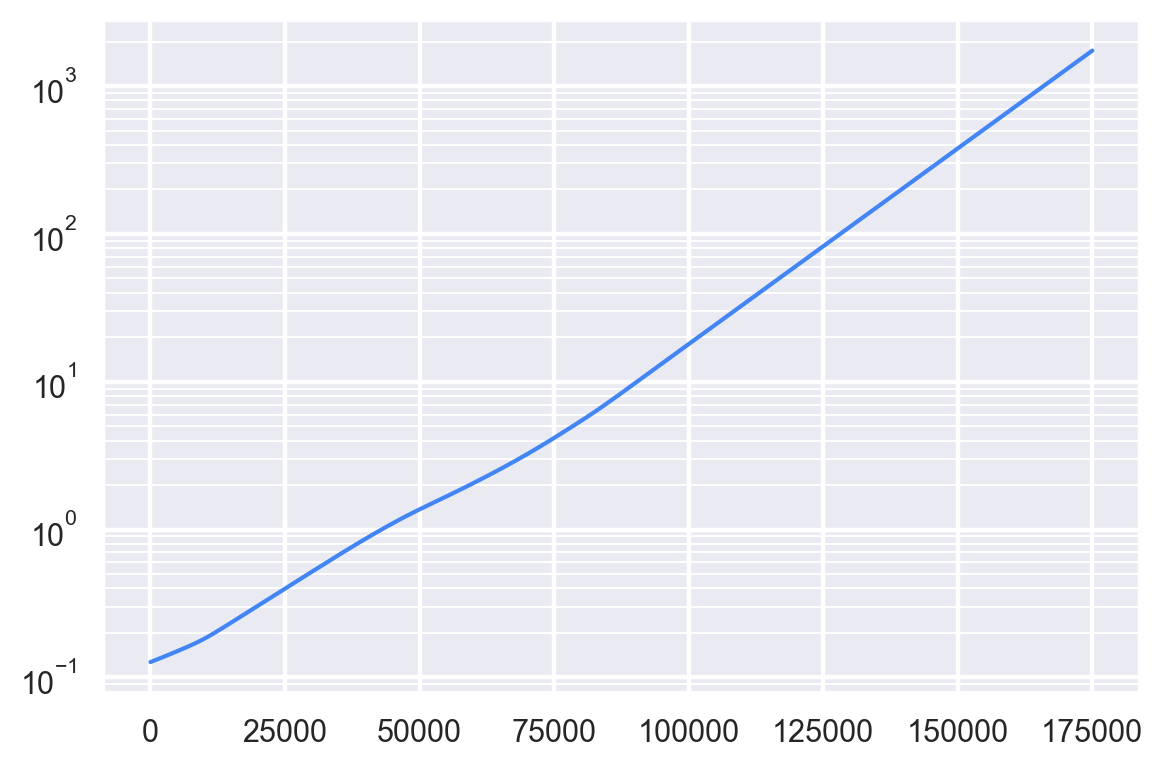

In [439]:
volume = (  # PV=nRT
        mass_helium /
        helium_molar_mass *
        gas_constant_universal *
        dyn.op_point.atmosphere.temperature() /  # Note, the temperature changes significantly with altitude
        dyn.op_point.atmosphere.pressure()
)
radius = (volume * 3 / 4 / np.pi) ** (1 / 3)
fig, ax = plt.subplots()
plt.semilogy(dyn.altitude, radius)
p.show_plot()